In [1]:
BASE_DIR  = r"E:\AIML"
DATA_PATH = rf"E:\AIML\dataset\heart_attack_prediction_dataset.csv"
EDA_DIR   = rf"E:\AIML\results\eda_visualizations"
OUT_DIR   = rf"E:\AIML\results\outputs"

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

try:
    from imblearn.over_sampling import SMOTE
except Exception:
    SMOTE = None  

warnings.filterwarnings("ignore")
os.makedirs(EDA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

TARGET = "Heart Attack Risk"
RANDOM_STATE = 42


In [2]:
df = pd.read_csv(DATA_PATH)
assert TARGET in df.columns, f"TARGET '{TARGET}' not found. Columns: {list(df.columns)}"

# optional: drop ID-like columns
id_like = {"patient id","id","record id"}
drop_ids = [c for c in df.columns if c.strip().lower() in id_like]
if drop_ids:
    df = df.drop(columns=drop_ids)

X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].values
strat = y if pd.Series(y).nunique() <= 20 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=strat
)
print("Train/Test:", X_train.shape, X_test.shape)

Train/Test: (7010, 24) (1753, 24)


In [3]:
# --- Detect categorical vs numeric ---
LOW_CARD_AS_CAT = 12
categorical_cols = []
for c in X_train.columns:
    if X_train[c].dtype == "object":
        categorical_cols.append(c)
    else:
        if X_train[c].nunique(dropna=True) <= LOW_CARD_AS_CAT:
            categorical_cols.append(c)
numeric_cols = [c for c in X_train.select_dtypes(include="number").columns if c not in categorical_cols]
print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

Categorical: ['Sex', 'Blood Pressure', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere']
Numeric: ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides']


In [4]:
# --- Pre-req: Impute (load if available; else compute) ---
import os

train_imp_path = os.path.join(OUT_DIR, "X_train_imputed.csv")
test_imp_path  = os.path.join(OUT_DIR, "X_test_imputed.csv")

if os.path.exists(train_imp_path) and os.path.exists(test_imp_path):
    print("Loading imputed splits from outputs/...")
    X_train_imp = pd.read_csv(train_imp_path).drop(columns=[TARGET], errors="ignore")
    X_test_imp  = pd.read_csv(test_imp_path).drop(columns=[TARGET], errors="ignore")
else:
    print("Imputing locally (median numeric, most_frequent categorical)...")
    num_imputer = SimpleImputer(strategy="median")
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_train_num = num_imputer.fit_transform(X_train[numeric_cols]) if numeric_cols else None
    X_test_num  = num_imputer.transform(X_test[numeric_cols])      if numeric_cols else None
    X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols]) if categorical_cols else None
    X_test_cat  = cat_imputer.transform(X_test[categorical_cols])      if categorical_cols else None
    tr_parts, te_parts = [], []
    if X_train_num is not None:
        tr_parts.append(pd.DataFrame(X_train_num, columns=numeric_cols, index=X_train.index))
        te_parts.append(pd.DataFrame(X_test_num,  columns=numeric_cols, index=X_test.index))
    if X_train_cat is not None:
        tr_parts.append(pd.DataFrame(X_train_cat, columns=categorical_cols, index=X_train.index))
        te_parts.append(pd.DataFrame(X_test_cat,  columns=categorical_cols, index=X_test.index))
    X_train_imp = pd.concat(tr_parts, axis=1) if tr_parts else pd.DataFrame(index=X_train.index)
    X_test_imp  = pd.concat(te_parts, axis=1) if te_parts else pd.DataFrame(index=X_test.index)

print("Imputed shapes:", X_train_imp.shape, X_test_imp.shape)

Loading imputed splits from outputs/...
Imputed shapes: (7010, 24) (1753, 24)


After scaling -> TRAIN: (7010, 24)  TEST: (1753, 24)


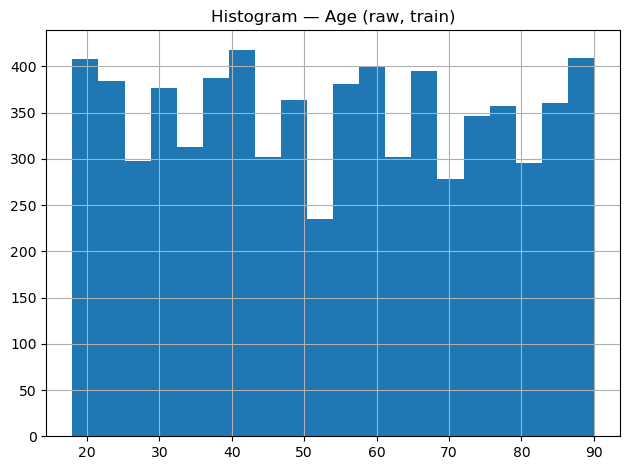

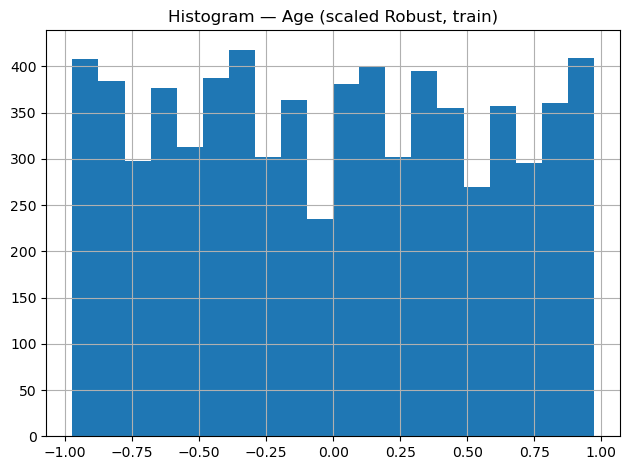

Saved: D_X_train_scaled.csv, D_X_test_scaled.csv


In [5]:
# --- D1: Scale numeric features (fit on TRAIN only) ---
USE_ROBUST_SCALER = True
scaler = RobustScaler() if USE_ROBUST_SCALER else StandardScaler()

num_cols = [c for c in X_train_imp.columns if c in X_train.select_dtypes(include="number").columns]
Xtr_num = X_train_imp[num_cols].values if num_cols else np.empty((len(X_train_imp),0))
Xte_num = X_test_imp[num_cols].values  if num_cols else np.empty((len(X_test_imp), 0))

if Xtr_num.shape[1] > 0:
    Xtr_num_s = scaler.fit_transform(Xtr_num)
    Xte_num_s = scaler.transform(Xte_num)
else:
    Xtr_num_s, Xte_num_s = Xtr_num, Xte_num

df_tr_num_s = pd.DataFrame(Xtr_num_s, columns=num_cols, index=X_train_imp.index)
df_te_num_s = pd.DataFrame(Xte_num_s, columns=num_cols, index=X_test_imp.index)

# Replace numeric columns with scaled values; keep non-numerics as-is
non_num_cols = [c for c in X_train_imp.columns if c not in num_cols]
X_train_scaled = pd.concat([df_tr_num_s, X_train_imp[non_num_cols]], axis=1)[X_train_imp.columns]
X_test_scaled  = pd.concat([df_te_num_s,  X_test_imp[non_num_cols]],  axis=1)[X_test_imp.columns]

print("After scaling -> TRAIN:", X_train_scaled.shape, " TEST:", X_test_scaled.shape)

# Histogram before vs after for a demo numeric column
if num_cols:
    demo = num_cols[0]
    plt.figure(); X_train_imp[demo].dropna().hist(bins=20)
    plt.title(f"Histogram — {demo} (raw, train)"); plt.tight_layout()
    plt.savefig(os.path.join(EDA_DIR, f"D_hist_raw_{demo}.png")); plt.show()

    plt.figure(); df_tr_num_s[demo].dropna().hist(bins=20)
    plt.title(f"Histogram — {demo} (scaled {'Robust' if USE_ROBUST_SCALER else 'Standard'}, train)"); plt.tight_layout()
    plt.savefig(os.path.join(EDA_DIR, f"D_hist_scaled_{demo}.png")); plt.show()

# Save scaled splits
pd.concat([X_train_scaled, pd.Series(y_train, index=X_train_scaled.index, name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "D_X_train_scaled.csv"), index=False)
pd.concat([X_test_scaled,  pd.Series(y_test,  index=X_test_scaled.index,  name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "D_X_test_scaled.csv"),  index=False)
print("Saved: D_X_train_scaled.csv, D_X_test_scaled.csv")